In [1]:
import tensorflow as tf

In [2]:
tf.reset_default_graph()
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('Stockmodel/model_7_fixdays_15_2_buy/Stock_InceptionResnet_100.ckpt.meta')
    #saver.restore(sess, tf.train.latest_checkpoint('Stockmodel/model_4/'))
    sess.run(tf.global_variables_initializer())
#     train_vars = tf.trainable_variables()
#     all_vars   = tf.global_variables()
#     for v in all_vars:
#         if "InceptionResnet_Stock" in v.name :
#             print("%s with value" % (v.name))# , sess.run(v)))
#     for v in [n.name for n in tf.get_default_graph().as_graph_def().node]:
#         print(v)
#     for v in tf.get_default_graph().get_operations():
#         print(v)
    for v in [tensor for op in tf.get_default_graph().get_operations() for tensor in op.values()]:
        if   "weights" in v.name or "biases" in v.name: continue
        if   "Placeholder" in v.name or "Prediction" in v.name: 
            print(v)
        elif node.dtype not in [tf.float32, tf.int32]: 
            print(v)
            

AttributeError: module 'tensorflow' has no attribute 'reset_default_graph'

In [27]:
tf.reset_default_graph()
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('Stockmodel/model_7_fixdays_15_2_buy/Stock_InceptionResnet_100.ckpt.meta')
    #saver.restore(sess, tf.train.latest_checkpoint('Stockmodel/model_4/'))
    sess.run(tf.global_variables_initializer())
#     train_vars = tf.trainable_variables()
#     all_vars   = tf.global_variables()
#     for v in all_vars:
#         if "InceptionResnet_Stock" in v.name :
#             print("%s with value" % (v.name))# , sess.run(v)))
#     for v in [n.name for n in tf.get_default_graph().as_graph_def().node]:
#         print(v)
#     for v in tf.get_default_graph().get_operations():
#         print(v)
    for v in [tensor for op in tf.get_default_graph().get_operations() for tensor in op.values()]:
        print(v); continue
        if   "Placeholder" in v.name or "Prediction" in v.name: 
            print(v)
        elif node.dtype not in [tf.float32, tf.int32]: 
            print(v)

Tensor("Placeholder:0", shape=(1, ?, 22, 1), dtype=float32)
Tensor("Placeholder_1:0", shape=(1, 1), dtype=float32)
Tensor("Placeholder_2:0", shape=(1, 3), dtype=float32)
Tensor("loss_ratio/input:0", shape=(), dtype=float32)
Tensor("loss_ratio:0", shape=(), dtype=float32)
Tensor("is_training/input:0", shape=(), dtype=bool)
Tensor("is_training:0", shape=(), dtype=bool)
Tensor("InceptionResnet_Stock/InceptionResnet_Stock/MirrorPad/paddings:0", shape=(4, 2), dtype=int32)
Tensor("InceptionResnet_Stock/InceptionResnet_Stock/MirrorPad:0", shape=(1, ?, 24, 1), dtype=float32)
Tensor("InceptionResnet_Stock/Conv2d_1a_3x3/weights/Initializer/random_uniform/shape:0", shape=(4,), dtype=int32)
Tensor("InceptionResnet_Stock/Conv2d_1a_3x3/weights/Initializer/random_uniform/min:0", shape=(), dtype=float32)
Tensor("InceptionResnet_Stock/Conv2d_1a_3x3/weights/Initializer/random_uniform/max:0", shape=(), dtype=float32)
Tensor("InceptionResnet_Stock/Conv2d_1a_3x3/weights/Initializer/random_uniform/RandomUni

In [1]:
#data
fix_days = 15
tp       = 0.03
sl       = 0.02
directT  = "B"

parameter_Order = [0,1,2,0,1,3,0,2,1,0,2,3,0,3,1,0,3,2,1,3,0,1]
parameterN      = len(parameter_Order)
valDays         = ["2018-1-1","2020-1-1"]

import numpy as np
import fixDay_preprocess_3 as preprocess

target_label    ='fix_{0}days_tp{1:d}_sl{2:d}_labels_{3}'.format(fix_days, int(tp*100), int(sl*100), directT)

preprocess.preProcess(fix_days, tp, sl)
val_x  , val_y, timeRecord   = preprocess.grabData(label=target_label, startT=valDays[0]  , endT=valDays[1], getTime=True)



 #--------type_B
-1.0    1921
 0.0    1891
 1.0    1206
Name: fix_15days_tp3_sl2_labels_B, dtype: int64

 #--------type_S
-1.0    2181
 0.0    1577
 1.0    1260
Name: fix_15days_tp3_sl2_labels_S, dtype: int64


In [2]:
import tensorflow as tf
import time

model_path = "Stockmodel/model_7_fixdays_15_2_buy/Stock_InceptionResnet_100.ckpt"
detection_graph = tf.Graph()

preds = []
fmaps = []
fmapMaxs = []
mapConcats = []
f1s   = []

with tf.Session(graph=detection_graph) as sess:
    # Load the graph with the trained states
    loader = tf.train.import_meta_graph(model_path+'.meta')
    loader.restore(sess, model_path)

    # Get the tensors by their variable name
    node   = detection_graph.get_tensor_by_name("Placeholder:0")
    rangeV = detection_graph.get_tensor_by_name("Placeholder_1:0")
    ans    = detection_graph.get_tensor_by_name("Placeholder_2:0")
    
    pred   = detection_graph.get_tensor_by_name("InceptionResnet_Stock/Logits/Predictions:0")
    
    featuremap    = detection_graph.get_tensor_by_name("InceptionResnet_Stock/InceptionResnet_Stock/Conv2d_base_structure_1_1x1/Relu:0")
    featuremapMax = detection_graph.get_tensor_by_name("InceptionResnet_Stock/Logits/Max:0")
    featureconcat = detection_graph.get_tensor_by_name("InceptionResnet_Stock/Logits/concat:0")
    feature_w1    = detection_graph.get_tensor_by_name("InceptionResnet_Stock/Logits/Logits/weights:0")

    # Make predictions
    a = time.time()
    for (x1,x2), y in zip(val_x, val_y):
        
        ratio = np.argmax(y)
        pred0, fmap, fmapsMax, mapsconcat, f1 = sess.run([pred, featuremap, featuremapMax, featureconcat, feature_w1], 
                                          feed_dict={node      : x1[np.newaxis, :,parameter_Order, np.newaxis], 
                                                     rangeV    : np.float32([x2])[np.newaxis, :],
                                                     ans       : y[np.newaxis,:] })
        preds.append(pred0)
        fmaps.append(fmap)
        fmapMaxs.append(fmapsMax)
        mapConcats.append(mapsconcat)
        f1s.append(f1)
print("{0:.3f}".format(time.time()-a))
    

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from Stockmodel/model_7_fixdays_15_2_buy/Stock_InceptionResnet_100.ckpt
30.821


In [3]:
preds = np.array(preds).reshape(-1,3)
# fmaps = np.array(fmaps)
# fmapMaxs = np.array(fmapMaxs)
mapConcats = np.array(mapConcats)
f1s = np.array(f1s)

In [4]:
pred_ans = np.argmax(preds, axis=1)
true_ans = np.argmax(val_y, axis=1)
right_ans= np.where(np.argmax(preds, axis=1)==np.argmax(val_y, axis=1))[0]

In [5]:
#detect model result
print("p-t")
for i in range(3):
    for i2 in range(3):
        print("{0}-{1} {2}".format(i, i2, np.sum(np.all([pred_ans==i, true_ans==i2],axis=0))))
print("\n",len(preds))

p-t
0-0 138
0-1 31
0-2 80
1-0 2
1-1 41
1-2 11
2-0 62
2-1 54
2-2 83

 502


In [6]:
# pos = np.where(np.all([np.argmax(preds, axis=1)==1, np.argmax(val_y, axis=1)==1], axis=0))[0]
# for i in pos:
#     print(i,"  len=",  val_x[i][0].shape,"timeRecord=", timeRecord[i],"pred=",preds[i])
#263

In [7]:
import datetime
import pandas as pd

def History_Report(data, timeRecord, preds, inType=[1], fixdays=15, tp=0.03, sl=0.02, commission=0.005, limitdays=3):
    data0 = np.array(data[['open','close']].copy())
    poses = np.where(np.any([np.argmax(preds, axis=1)==t for t in inType], axis=0))[0]
    p0    = None
    for pos in poses:
        d2 = datetime.datetime(*np.int32(timeRecord[pos].strftime("%Y-%m-%d").split("-")))
        n  = np.where(data.index>=d2)[0][0]

        # B
        tp0= data0[n,0] + data0[n,0]*tp
        sl0= data0[n,0] - data0[n,0]*sl

        tpn= np.where(data0[n+limitdays-1:n+fixdays,1]>=tp0)[0]
        sln= np.where(data0[n+limitdays-1:n+fixdays,1]<=sl0)[0]
        tpn= tpn[0]+n+limitdays-1 if len(tpn)!=0 else n+fixdays
        sln= sln[0]+n+limitdays-1 if len(sln)!=0 else n+fixdays

        fin= min(min(min(tpn,sln), n+fixdays-1),len(data0)-1)
        p1 = pd.DataFrame({"InDate"         : [data.index[n].to_pydatetime().strftime("%Y-%m-%d")],
                           "OutDate"        : [data.index[fin].to_pydatetime().strftime("%Y-%m-%d")],
                           "LotType"        : ["B"],
                           "InPrice"        : [data0[n,0]],
                           "OutPrice"       : [data0[fin,1]],
                           "Profit"         : [data0[fin,1]-data0[n,0]],
                           "Net Profit"     : [data0[fin,1]-data0[n,0]*(1+commission)],
                           "Profit rate"    : [(data0[fin,1]-data0[n,0])/data0[n,0]],
                           "Net Profit rate": [(data0[fin,1]-data0[n,0])/data0[n,0]-commission],
                           "Commission"     : [commission],
                           "InPos"          : [n],                      
                           "OutPos"         : [fin]
                          })
        if p0 is None: 
            p0 = p1
        else :
            p0 = p0.append(p1) 
    return p0

LotsReport = History_Report(preprocess.k_plot, timeRecord, preds, inType=[1], fixdays=15, tp=0.03, sl=0.02, commission=0.005, limitdays=3)
# LotsReport.to_csv("Lots_Report.csv", index=False)

In [8]:
import numpy as np
from scipy import interpolate
import pylab as pl
import matplotlib.pyplot as plt

path = "Report/model_7_fixdays_15_2_buy/Total/record"
featureN = 0 #"N:0/ B:1/ S:2 "
colors   = ["mediumblue", "r", 'g']

for label_i in range(len(val_y)):
    featureN= np.argmax(preds[label_i])
    record  = np.zeros([fmaps[label_i].shape[1]], dtype=np.float32)

    a = f1s[label_i][:,featureN]
    b = mapConcats[label_i].reshape([-1])
    c = (a*b)

    for i,v in enumerate(c[:1024]):
        pos = np.argmax(fmapMaxs[label_i][0,i,:])
        record[pos] = record[pos]+v

    for i,v0 in enumerate(c[2048:-1].reshape([-1,5])):
        for i2, v in enumerate(v0):
            record[i2-5] = record[i2-5]+v
        
    disLook = c[-1]
    
    shape = val_x[label_i][0].shape[0]
    
    n   =len(record)
    mul =val_x[label_i][0].shape[0]/n 
    x   =np.linspace(0, n*mul-1, n)
    y   =record
    xnew=np.linspace(0,n*mul-1,shape)
    
    f=interpolate.interp1d(x,y,kind="quadratic")
    ynew=f(xnew)
    
    d2 = np.int32(timeRecord[label_i].strftime("%Y-%m-%d").split("-"))
    
    preprocess.K_plot(preprocess.k_plot, d1=shape, d2=d2, Indicator=ynew, Main=None, name="{0}_{1}.jpg".format(path, label_i), color=colors[featureN], report=LotsReport)
    plt.close('all')


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def write(img, w, loc, color, size=1):
    cv2.putText(img, w, loc, cv2.FONT_HERSHEY_COMPLEX, size, color, 2)
    
def recordTable(img, Orders, Simple, Compound, Commission=0.5):
    colors = [0,0,0,0]
    for i in  range(2):
        colors[i*2]   = (0,128,255)  if Simple[i]  >=0 else (127, 255, 0)
        colors[i*2+1] = (0,128,255)  if Compound[i]>=0 else (127, 255, 0)
        Simple[i]   = "+"+str(round(Simple[i],2))   if Simple[i]  >=0 else str(round(Simple[i],2))
        Compound[i] = "+"+str(round(Compound[i],2)) if Compound[i]>=0 else str(round(Compound[i],2))
        
    write(img, w="{0:<12}".format('Commission:'), loc=(1070,200), color=(0,0,0))
    write(img, w="{0:>8}%".format(Commission), loc=(1320,200), color=(0,0,0))

    write(img, w="{0:<12}".format('Orders:'), loc=(1070,250), color=(0,0,0))
    write(img, w="{0:>8} ".format(Orders), loc=(1320,250), color=(0,0,0))

    write(img, w="{0:<12} ".format('Simple Interest:'), loc=(1070,300), color=(0,0,0))
    write(img, w=" - {0:<9}".format('Balance:'), loc=(1070,350), color=(0,0,0), size=0.8)
    write(img, w="{0:>8}%".format(Simple[0]), loc=(1320,350), color=colors[0])
    write(img, w=" - {0:<9}".format('Profit/Loss:'), loc=(1070,400), color=(0,0,0), size=0.8)
    write(img, w="{0:>8}%".format(Simple[1]), loc=(1320,400), color=colors[2])

    write(img, w="{0:<12} ".format('Compound Interest:'), loc=(1070,450), color=(0,0,0))
    write(img, w=" - {0:<9}".format('Balance:'), loc=(1070,500), color=(0,0,0), size=0.8)
    write(img, w="{0:>8}%".format(Compound[0]), loc=(1320,500), color=colors[1])
    write(img, w=" - {0:<9}".format('Profit/Los:'), loc=(1070,550), color=(0,0,0), size=0.8)
    write(img, w="{0:>8}%".format(Compound[1]), loc=(1320,550), color=colors[3])
    
def RecordData(data, timeRecord, report, inPath, outPath, Commission=0.005):
    Acount_S = {}
    Acount_C = {}
    Balance_S, Balance_C = 1, 1
    
    data0 = np.array(data[['open','close']].copy())
    data1 = np.array(report[['InPos', 'OutPos']].copy())
    d2 = datetime.datetime(*np.int32(timeRecord[0].strftime("%Y-%m-%d").split("-")))
    n  = np.where(data.index>=d2)[0][0]
    for i in range(len(timeRecord)):
        #Out
        pos = np.where(data1[:,1]==n+i)[0]
        if len(pos)>0:
            for pi in range(len(pos)):
                Balance_S += ((data0[n+i,1]-Acount_S[data1[pos[pi],0]][1])/Acount_S[data1[pos[pi],0]][1]-Commission)*Acount_S[data1[pos[pi],0]][0] 
                Balance_C += ((data0[n+i,1]-Acount_C[data1[pos[pi],0]][1])/Acount_C[data1[pos[pi],0]][1]-Commission)*Acount_C[data1[pos[pi],0]][0]
                del Acount_S[data1[pos[pi],0]]
                del Acount_C[data1[pos[pi],0]]
        
        #In
        pos = np.where(data1[:,0]==n+i)[0]
        if len(pos)>0:
            Acount_S[data1[pos[0],0]]=[        1,data0[n+i,0]]
            Acount_C[data1[pos[0],0]]=[Balance_C,data0[n+i,0]]
        
        #Insitu
        Profit_S, Profit_C = 0, 0
        for v in Acount_S.values():
            Profit_S += ((data0[n+i,1]-v[1])/v[1]-Commission)*v[0]
        for v in Acount_C.values():
            Profit_C += ((data0[n+i,1]-v[1])/v[1]-Commission)*v[0]
        
        #draw
        img = cv2.imread(inPath.format(i),1)

        img2 = np.ones([720,1520,3])*255
        img2[:,:1224-80,:] = img[:,80:,:]
        
        cv2.rectangle(img2, (1050,150), (1510,580), (50,50,50), 1)
        recordTable(img2, Orders=len(Acount_S), Simple=[(Balance_S-1)*100, Profit_S], Compound=[(Balance_C-1)*100, Profit_C], Commission=Commission*100)

        cv2.imwrite(outPath.format(i), img2)
       

In [ ]:
RecordData(preprocess.k_plot, 
           timeRecord = timeRecord, 
           report     = LotsReport, 
           inPath     = "Report/model_7_fixdays_15_2_buy/Total/record_{0}.jpg", 
           outPath    = "Report/model_7_fixdays_15_2_buy/Record/record_{0}.jpg")

In [15]:
import cv2
end_n = 501

img = cv2.imread("Report/model_7_fixdays_15_2_buy/Record/record_{0}.jpg".format(end_n), 1)

center = [525, 365]
bias   = [275, 125]
expandN= 5

for i in range(expandN+1):
    cv2.rectangle(img, (center[0]-int(bias[0]/expandN*i), center[1]-int(bias[1]/expandN*i)), (center[0]+int(bias[0]/expandN*i), center[1]+int(bias[1]/expandN*i)), (50,50,50), 1)
    img[center[1]-int(bias[1]/expandN*i)+1:center[1]+int(bias[1]/expandN*i), center[0]-int(bias[0]/expandN*i)+1:center[0]+int(bias[0]/expandN*i), :] = 255
    end_n=end_n+1; cv2.imwrite("Report/model_7_fixdays_15_2_buy/Record/record_{0}.jpg".format(end_n), img)

write(img, w="2018/01/01 - 2019/12/31 ", loc=(300, 300), color=(0, 0, 0), size=1)
end_n=end_n+1; cv2.imwrite("Report/model_7_fixdays_15_2_buy/Record/record_{0}.jpg".format(end_n), img)

write(img, w="Take Profit Lots  :  42", loc=(300, 350), color=(0, 0, 0), size=1)
write(img, w="Stop Loss Lots    :  11", loc=(300, 400), color=(0, 0, 0), size=1)
write(img, w="Time Expire Lots :   2", loc=(300, 450), color=(0, 0, 0), size=1) #(207, 174, 78)
end_n=end_n+1; cv2.imwrite("Report/model_7_fixdays_15_2_buy/Record/record_{0}.jpg".format(end_n), img)


True

# Create Video

In [17]:
import cv2
from cv2 import VideoWriter,VideoWriter_fourcc,imread,resize
import glob, os
img_root="Report/model_7_fixdays_15_2_buy/Record/record_{0}.jpg"
shape   = cv2.imread(img_root.format(0),1).shape[:2][::-1]

#Edit each frame's appearing time!
fps=5
fourcc=VideoWriter_fourcc('m', 'p', '4', 'v')
videoWriter=cv2.VideoWriter("Test-Back_without_Audio.mp4",fourcc,fps,shape)

n = len(glob.glob(os.sep.join(img_root.split(os.sep)[:-1] + ["*.jpg"])))
for i in range(n):
    imgpath = img_root.format(i)
    frame=cv2.imread(imgpath, 1)
    videoWriter.write(frame)
	
videoWriter.release()

In [29]:
import ffmpeg

audioPath = "Report/Brand_X_Music-Buccaneer_Island.mp3"
videoPath = "Test-Back_without_Audio.mp4"
output    = "Report/Test-Back_2.mp4"

video = ffmpeg.input(videoPath)
audio = ffmpeg.input(audioPath)

ffmpeg.concat(video, audio, v=1, a=1).output(output).run(overwrite_output=True)

(None, None)

In [ ]:
import ffmpeg


input_video = ffmpeg.input("../resources/video_with_audio.mp4")
added_audio = ffmpeg.input("../resources/dance_beat.ogg").audio.filter('adelay', "1500|1500")

merged_audio = ffmpeg.filter([input_video.audio, added_audio], 'amix')

(
    ffmpeg
    .concat(input_video, merged_audio, v=1, a=1)
    .output("mix_delayed_audio.mp4")
    .run(overwrite_output=True)
)

In [25]:
import moviepy.editor as mp



audio = mp.AudioFileClip(audioPath)
video = mp.VideoFileClip(videoPath)
final = mp.concatenate_videoclips([video])
# video = video.set_duration(audio)
final = final.set_audio(audio.set_duration(final))
# video1.set_audio(audio)
#video2 = mp.VideoFileClip("video2.mp4")
# final = mp.concatenate_videoclips([video1, video2]).set_audio(audio)
# final.write_videofile("output.mp4")
final.write_videofile("Report/Test-Back_2.mp4")

TypeError: unsupported operand type(s) for +: 'int' and 'VideoClip'

In [18]:
from moviepy.editor import VideoFileClip, AudioFileClip
 
clip_video = VideoFileClip("Test-Back_without_Audio.mp4")
clip_audio = AudioFileClip('Report/Brand_X_Music-Buccaneer_Island.mp3')

new_video = clip_video.set_audio(clip_audio)
new_video.write_videofile("Report/Test-Back.mp4")

chunk:   2%|▏         | 44/2508 [00:00<00:05, 426.03it/s, now=None]

Moviepy - Building video Report/Test-Back.mp4.
MoviePy - Writing audio in Test-BackTEMP_MPY_wvf_snd.mp3


t:   3%|▎         | 16/510 [00:00<00:03, 156.82it/s, now=None]       

MoviePy - Done.
Moviepy - Writing video Report/Test-Back.mp4



Moviepy - Done !
Moviepy - video ready Report/Test-Back.mp4


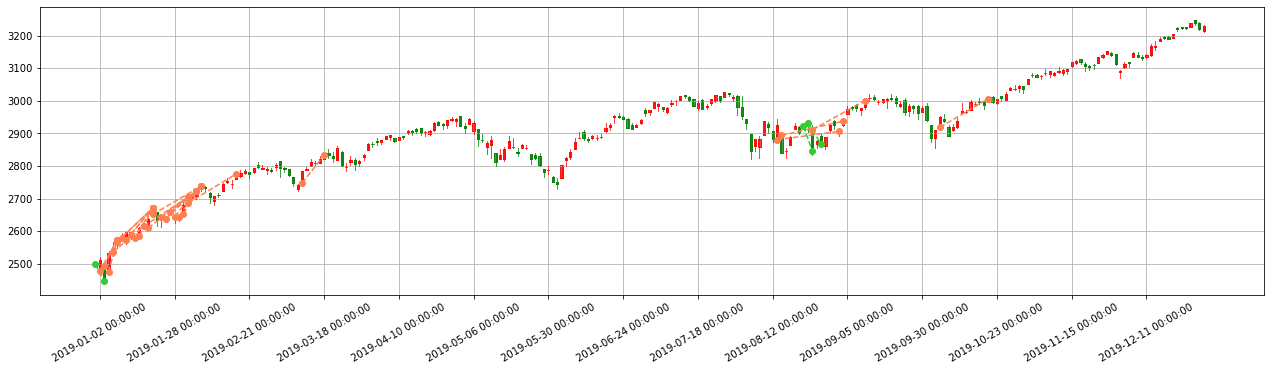

In [61]:
# K_plot(preprocess.k_plot, d1=(2019, 1, 1), d2=(2020, 1, 1), Indicator=None, Main=None, name='', color='mediumblue', report=LotsReport)

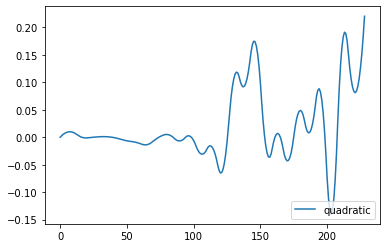

In [19]:
import numpy as np
from scipy import interpolate
import pylab as pl

n   =len(record)
mul =val_x[label_i][0].shape[0]/n 
x   =np.linspace(0, n*mul-1, n)
y   =record
xnew=np.linspace(0,n*mul-1,shape)
#pl.plot(x,y,"ro")

for kind in ["quadratic"]:#插值方式 #["nearest","zero","slinear","quadratic","cubic"]
    #"nearest","zero"为阶梯插值
    #slinear 线性插值
    #"quadratic","cubic" 为2阶、3阶B样条曲线插值
    f=interpolate.interp1d(x,y,kind=kind)
    # ‘slinear’, ‘quadratic’ and ‘cubic’ refer to a spline interpolation of first, second or third order)
    ynew=f(xnew)
    pl.plot(xnew,ynew,label=str(kind))
pl.legend(loc="lower right")
pl.show()

數量= 229


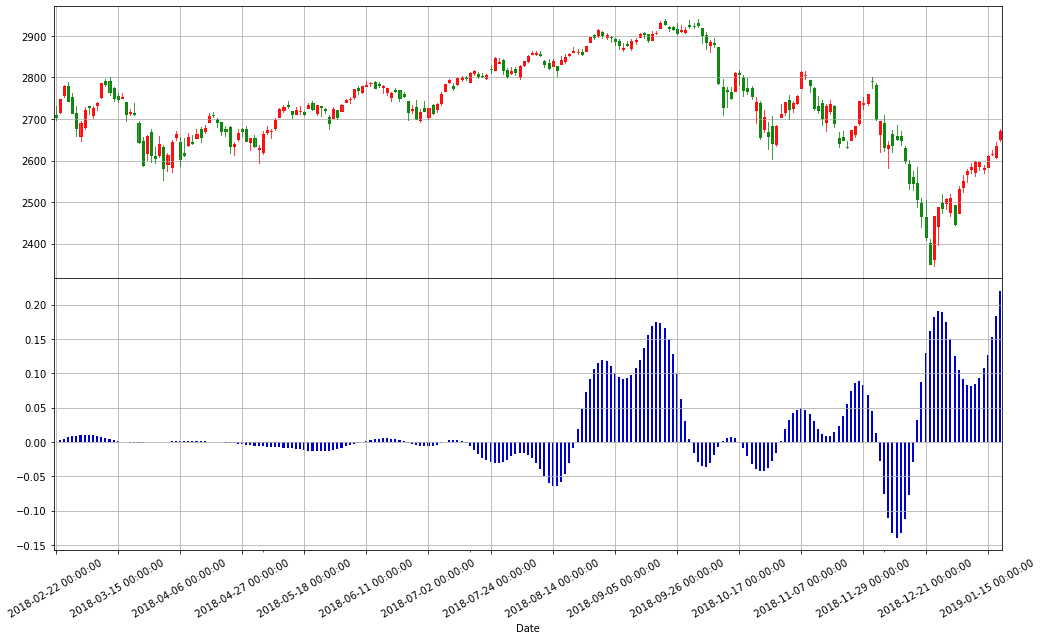

In [20]:
# preprocess.K_plot(preprocess.k_plot, d1=229, d2=d2, Indicator=ynew, Main=None, name='')

In [9]:


img = cv2.imread("Report/model_7_fixdays_15_2_buy/Total/record_8.jpg",1)

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def write(img, w, loc, color, size=1):
    cv2.putText(img, w, loc, cv2.FONT_HERSHEY_COMPLEX, size, color, 2)
    
def recordTable(img, Orders, Simple, Compound, Commission=0.5):
    colors = [0,0,0,0]
    for i in  range(2):
        colors[i*2]   = (0,128,255)  if Simple[i]  >=0 else (127, 255, 0)
        colors[i*2+1] = (0,128,255)  if Compound[i]>=0 else (127, 255, 0)
        Simple[i]   = "+"+str(round(Simple[i],2))   if Simple[i]  >=0 else str(round(Simple[i],2))
        Compound[i] = "+"+str(round(Compound[i],2)) if Compound[i]>=0 else str(round(Compound[i],2))
        
    write(img, w="{0:<12}".format('Commission:'), loc=(1070,200), color=(0,0,0))
    write(img, w="{0:>8}%".format(Commission), loc=(1320,200), color=(0,0,0))

    write(img, w="{0:<12}".format('Orders:'), loc=(1070,250), color=(0,0,0))
    write(img, w="{0:>8} ".format(Orders), loc=(1320,250), color=(0,0,0))

    write(img, w="{0:<12} ".format('Simple Interest:'), loc=(1070,300), color=(0,0,0))
    write(img, w=" - {0:<9}".format('Balance:'), loc=(1070,350), color=(0,0,0), size=0.8)
    write(img, w="{0:>8}%".format(Simple[0]), loc=(1320,350), color=colors[0])
    write(img, w=" - {0:<9}".format('Profit/Loss:'), loc=(1070,400), color=(0,0,0), size=0.8)
    write(img, w="{0:>8}%".format(Simple[1]), loc=(1320,400), color=colors[2])

    write(img, w="{0:<12} ".format('Compound Interest:'), loc=(1070,450), color=(0,0,0))
    write(img, w=" - {0:<9}".format('Balance:'), loc=(1070,500), color=(0,0,0), size=0.8)
    write(img, w="{0:>8}%".format(Compound[0]), loc=(1320,500), color=colors[1])
    write(img, w=" - {0:<9}".format('Profit/Los:'), loc=(1070,550), color=(0,0,0), size=0.8)
    write(img, w="{0:>8}%".format(Compound[1]), loc=(1320,550), color=colors[3])
    
def RecordData(data, timeRecord, report, inPath, outPath, Commission=0.005):
    Acount_S = {}
    Acount_C = {}
    Balance_S, Balance_C = 1, 1
    
    data0 = np.array(data[['open','close']].copy())
    data1 = np.array(report[['InPos', 'OutPos']].copy())
    d2 = datetime.datetime(*np.int32(timeRecord[0].strftime("%Y-%m-%d").split("-")))
    n  = np.where(data.index>=d2)[0][0]
    for i in range(len(timeRecord)):
        #Out
        pos = np.where(data1[:,1]==n+i)[0]
        if len(pos)>0:
            for pi in range(len(pos)):
                Balance_S += ((data0[n+i,1]-Acount_S[data1[pos[pi],0]][1])/Acount_S[data1[pos[pi],0]][1]-Commission)*Acount_S[data1[pos[pi],0]][0] 
                Balance_C += ((data0[n+i,1]-Acount_C[data1[pos[pi],0]][1])/Acount_C[data1[pos[pi],0]][1]-Commission)*Acount_C[data1[pos[pi],0]][0]
                del Acount_S[data1[pos[pi],0]]
                del Acount_C[data1[pos[pi],0]]
        
        #In
        pos = np.where(data1[:,0]==n+i)[0]
        if len(pos)>0:
            Acount_S[data1[pos[0],0]]=[        1,data0[n+i,0]]
            Acount_C[data1[pos[0],0]]=[Balance_C,data0[n+i,0]]
        
        #Insitu
        Profit_S, Profit_C = 0, 0
        for v in Acount_S.values():
            Profit_S += ((data0[n+i,1]-v[1])/v[1]-Commission)*v[0]
        for v in Acount_C.values():
            Profit_C += ((data0[n+i,1]-v[1])/v[1]-Commission)*v[0]
        
        #draw
        img = cv2.imread(inPath.format(i),1)

        img2 = np.ones([720,1520,3])*255
        img2[:,:1224-80,:] = img[:,80:,:]
        
        cv2.rectangle(img2, (1050,150), (1510,580), (50,50,50), 1)
        recordTable(img2, Orders=len(Acount_S), Simple=[(Balance_S-1)*100, Profit_S], Compound=[(Balance_C-1)*100, Profit_C], Commission=Commission*100)

        cv2.imwrite(outPath.format(i), img2)
       

In [25]:
RecordData(preprocess.k_plot, 
           timeRecord = timeRecord, 
           report     = LotsReport, 
           inPath     = "Report/model_7_fixdays_15_2_buy/Total/record_{0}.jpg", 
           outPath    = "Report/model_7_fixdays_15_2_buy/Record/record_{0}.jpg")

In [27]:
import glob
a = glob.glob('Report/model_7_fixdays_15_2_buy/Total/*.jpg')
sorted(a)[:20]

['Report/model_7_fixdays_15_2_buy/Total/record_0.jpg',
 'Report/model_7_fixdays_15_2_buy/Total/record_1.jpg',
 'Report/model_7_fixdays_15_2_buy/Total/record_10.jpg',
 'Report/model_7_fixdays_15_2_buy/Total/record_100.jpg',
 'Report/model_7_fixdays_15_2_buy/Total/record_101.jpg',
 'Report/model_7_fixdays_15_2_buy/Total/record_102.jpg',
 'Report/model_7_fixdays_15_2_buy/Total/record_103.jpg',
 'Report/model_7_fixdays_15_2_buy/Total/record_104.jpg',
 'Report/model_7_fixdays_15_2_buy/Total/record_105.jpg',
 'Report/model_7_fixdays_15_2_buy/Total/record_106.jpg',
 'Report/model_7_fixdays_15_2_buy/Total/record_107.jpg',
 'Report/model_7_fixdays_15_2_buy/Total/record_108.jpg',
 'Report/model_7_fixdays_15_2_buy/Total/record_109.jpg',
 'Report/model_7_fixdays_15_2_buy/Total/record_11.jpg',
 'Report/model_7_fixdays_15_2_buy/Total/record_110.jpg',
 'Report/model_7_fixdays_15_2_buy/Total/record_111.jpg',
 'Report/model_7_fixdays_15_2_buy/Total/record_112.jpg',
 'Report/model_7_fixdays_15_2_buy/Tot

In [ ]:

import cv2
import numpy as np
import glob
 
img_array = []
for filename in glob.glob('Report/model_7_fixdays_15_2_buy/Total/*.jpg'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
 
out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [15]:
LotsReport

,InDate,OutDate,LotType,InPrice,OutPrice,Profit,Net Profit,Profit rate,Net Profit rate,Commission,InPos,OutPos
0,2018-03-02,2018-03-08,B,2658.89,2738.97,80.08,66.78555,0.030118,0.025118,0.005,4570,4574
0,2018-03-05,2018-03-09,B,2681.06,2786.57,105.51,92.10470,0.039354,0.034354,0.005,4571,4575
0,2018-03-07,2018-03-22,B,2710.18,2643.69,-66.49,-80.04090,-0.024533,-0.029533,0.005,4573,4584
0,2018-03-15,2018-03-22,B,2754.27,2643.69,-110.58,-124.35135,-0.040149,-0.045149,0.005,4579,4584
0,2018-03-16,2018-03-22,B,2750.57,2643.69,-106.88,-120.63285,-0.038857,-0.043857,0.005,4580,4584
0,2018-03-19,2018-03-22,B,2741.38,2643.69,-97.69,-111.39690,-0.035635,-0.040635,0.005,4581,4584
0,2018-04-04,2018-04-12,B,2584.04,2663.99,79.95,67.02980,0.030940,0.025940,0.005,4592,4598
0,2018-04-23,2018-05-11,B,2675.40,2727.72,52.32,38.94300,0.019556,0.014556,0.005,4605,4619
0,2018-04-24,2018-05-14,B,2680.80,2730.13,49.33,35.92600,0.018401,0.013401,0.005,4606,4620
0,2018-04-25,2018-05-10,B,2634.92,2723.07,88.15,74.97540,0.033455,0.028455,0.005,4607,4618


In [59]:
pred0

array([[0.49200946, 0.3510859 , 0.15690461]], dtype=float32)

In [69]:
f2

array([[-0.01846982, -0.0216423 ,  0.00268308],
       [ 0.01111085, -0.00183829,  0.02493211],
       [-0.02662258,  0.00582567,  0.00429164],
       ...,
       [-0.00877866,  0.02523265, -0.00037481],
       [-0.01526209,  0.00621243, -0.00980354],
       [-0.01318979,  0.00657556,  0.00035699]], dtype=float32)

In [32]:
f2

array([[ 0.00528171,  0.01890839, -0.01748473],
       [ 0.0278036 , -0.00969306,  0.00951026],
       [-0.02255839, -0.02030693, -0.00550864],
       ...,
       [ 0.01468889, -0.01838275, -0.01094868],
       [ 0.01652876,  0.00479982,  0.00399097],
       [-0.01215331, -0.00696515,  0.01424912]], dtype=float32)

In [33]:
f1

array([[ 2.7185187e-02,  2.2757140e-03, -7.3789433e-03],
       [-2.0850673e-02, -7.1048336e-03, -7.1226132e-05],
       [ 3.8356248e-03, -3.8728800e-03,  1.3928313e-02],
       ...,
       [ 5.6129671e-03,  2.8011831e-02, -8.8013913e-03],
       [-1.6232511e-02,  2.4311082e-03,  1.2719365e-02],
       [-8.4287850e-03, -2.5618048e-02, -1.5595672e-02]], dtype=float32)

In [35]:
fmaps.shape

(1, 8, 22, 1024)

In [49]:
for i,v in enumerate(fmapsMax[0,:,:]):
    print(v)
    if i>=10: break

[0.         0.         0.         0.         0.         0.
 0.         0.08457458]
[0.         0.         0.         0.44710088 0.9733638  1.4493415
 1.975847   2.5478826 ]
[0.         0.0289148  0.15959941 0.23077512 0.2994012  0.48899674
 0.4523982  0.4604222 ]
[0.30048248 0.27475303 0.08992283 0.         0.         0.
 0.         0.        ]
[0.         0.         0.         0.00793623 0.42568523 0.98524964
 1.3073049  1.474138  ]
[0.17528592 0.14304374 0.00961348 0.         0.         0.
 0.         0.        ]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0.         0.         0.         0.         0.         0.21843207
 0.50493044 0.482538  ]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0.         0.         0.         0.         0.         0.
 0.32139078 0.49948472]
[0.4261633  0.44841167 0.33722383 0.         0.         0.
 0.         0.        ]


In [51]:
mapsconcats[0, :10]

array([0.08457458, 2.5478826 , 0.48899674, 0.30048248, 1.474138  ,
       0.17528592, 0.        , 0.50493044, 0.        , 0.49948472],
      dtype=float32)

In [54]:
mapsconcats[0, 1024:1034]

array([1.        , 1.        , 0.33333334, 0.125     , 1.        ,
       0.125     , 1.        , 0.5       , 1.        , 1.        ],
      dtype=float32)

In [55]:
mapsconcats[0, 2048:2058]

array([0.        , 0.        , 0.        , 0.        , 0.08457458,
       0.44710088, 0.9733638 , 1.4493415 , 1.975847  , 2.5478826 ],
      dtype=float32)

In [56]:
f1.shape

(7169, 3)